<a href="https://colab.research.google.com/github/OlegBEZb/NLP_advanced_course/blob/master/HW2/HW2_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About notebook

Dataset
*	Groningen Meaning Bank (version 2.2.0)
*	Task: named entity recognition
*	Target – named entity tags (BIO + entity type)
*	Input data: 
  * Use “en.met” files to extract the subcorpus
  corpus = 'Voice of America' (for honogeneity of the input data set)
  * Use "en.tags" files for the main input data:
      *	raw tokens + may use the lemmas and the POS-tags 
  (i.e. take the “golden” POS-tagging);
      *	which means:
        *	first three columns for input: ['word', 'pos', 'lemma']
        *	the fourth column for target variable (‘ne_tags’)
        (BIO annotation + the named-entity type in one tag)  

# Tasks

1.	The most trivial model = supervised HMM:
  *	Take hmmlearn (former sklearn), modify MultinomialHMM (I.e. inherit a new class from _BaseHMM making it a modified copy of the latter) to allow for supervised HMM training. The states of the HMM model = the NE tags.
  *	NOTE: may use NaiveBayes to learn emission probabilities in a supervized manner.
  *	Or implement from scratch (with Viterbi for prediction).
  *	NOTE: use tuples of features for X (not just the word, but additional info).
  *	NOTE: use smoothing for state transitions.
2.	CRF
  *	Modify the input features;
  *	Use CRFSuite.
3.	Bi-LSTM:
  *	Use keras or tensorflow;
  *	https://github.com/hse-aml/natural-language-processing/blob/master/week2/week2-NER.ipynb
  *	A plus for incorporating CNN-layers;

# Metrics

* normalized confusion matrices, precision, recall, F-score 
(macro- and micro-) 
* (token level, entity level, partial matching (i.e. boundary-detection problem), binary).  
NOTE: taking into account vocabulary transfer is a plus.

http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/  
http://larsmans.github.io/seqlearn/reference.html#module-seqlearn.datasets

# Evaluation Criteria

Scoring (14.5 max):  
*	Dataset overview – 0.5
  *	text lengths, vocabulary size, frequencies of patterns (<UNK-type-i>) 
  *	stats over the target tags
*	Feature engineering – 2 (1+1)
  *	grammatical words = closed set (~ stop words)
  *	Stemming + POS
  *	Word shape
  *	Ad hoc features ( +1)  
*	Word patterns -> encode types of unknown words +0.5
*	Smoothing in HMM – 0.5 
  *	In HMM: for state transitions.
*	Incorporating tupled features in HMM (on top of tokens) – 1
*	The correct HMM implementation – 1
*	More fine-grained feature engineering for the Neural Network + 0.5
  *	Differentiate between POS-relevancy for the word and the context, etc.
  *	Sentence-level features (may use “golden” sentence-splitting)
*	Evaluation (on all levels) – 1
*	Conclusion on HMM deficiency (as a model) – 1
*	CRF: 1 point for use and evaluation, + 0.5 points for comparison and conclusions;
*	NN:
  *	Main network: 4
  *	CNN layers: +2  

Libraries: hmmlearn, crfsuite, tensorflow, keras

# Libs import

## Downloading, upgrading libs, fixing bugs in seqlearn

In [1]:
!pip install sklearn-crfsuite
!pip install -U scipy
!pip install seqlearn
!pip install seqeval
!pip install hmmlearn==0.2.2

     |████████████████████████████████| 747kB 3.4MB/s 
Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.4.1)
     |████████████████████████████████| 563kB 3.0MB/s 
  Created wheel for seqlearn: filename=seqlearn-0.2-cp36-cp36m-linux_x86_64.whl size=314729 sha256=6ba1e95ab1b586c7a4bdbda8fb8733642e7a9293d80126d3ab7efd513d49ff25
  Stored in directory: /root/.cache/pip/wheels/a7/bb/ba/a0b9c1a28f660d56616e0b75dd7a0e4d3d202a92fae5ede886
Successfully built seqlearn
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=58e5d44a2bce232326afbf8b6f4b9cd7a75296a69a5262ca9e6c8d86eb5271d0
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
     |████████████████████████████████| 153kB 3.3MB/s 
  Created wheel for hmmlearn: filename=hmmlearn-0.2.2-cp36-cp36m-linux_x86_64.whl size=326424 sha256=3a2fa2e2370b8075ab074610abbe0d4ef65b5b32877a52b934fc72f9bf5b

There is unsolved issue https://github.com/larsmans/seqlearn/issues/45  
And there is no opportunity to use lower version of scipy because of other dependencies  
Also there is a [bug](https://github.com/larsmans/seqlearn/pull/29) with calculating final probabilities which is fixed below

In [0]:
!rm /usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py

In [3]:
%%writefile /usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py

"""Hidden Markov models (HMMs) with supervised training."""

import numpy as np
#from scipy.misc import logsumexp
from scipy.special import logsumexp

from .base import BaseSequenceClassifier
from ._utils import atleast2d_or_csr, count_trans, safe_sparse_dot


class MultinomialHMM(BaseSequenceClassifier):
    """First-order hidden Markov model with multinomial event model.

    Parameters
    ----------
    decode : string, optional
        Decoding algorithm, either "bestfirst" or "viterbi" (default).
        Best-first decoding is also called posterior decoding in the HMM
        literature.

    alpha : float
        Lidstone (additive) smoothing parameter.
    """

    def __init__(self, decode="viterbi", alpha=.01):
        self.alpha = alpha
        self.decode = decode

    def fit(self, X, y, lengths):
        """Fit HMM model to data.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Feature matrix of individual samples.

        y : array-like, shape (n_samples,)
            Target labels.

        lengths : array-like of integers, shape (n_sequences,)
            Lengths of the individual sequences in X, y. The sum of these
            should be n_samples.

        Notes
        -----
        Make sure the training set (X) is one-hot encoded; if more than one
        feature in X is on, the emission probabilities will be multiplied.

        Returns
        -------
        self : MultinomialHMM
        """

        alpha = self.alpha
        if alpha <= 0:
            raise ValueError("alpha should be >0, got {0!r}".format(alpha))

        X = atleast2d_or_csr(X)
        classes, y = np.unique(y, return_inverse=True)
        lengths = np.asarray(lengths)
        Y = y.reshape(-1, 1) == np.arange(len(classes))

        end = np.cumsum(lengths)
        start = end - lengths

        init_prob = np.log(Y[start].sum(axis=0) + alpha)
        init_prob -= logsumexp(init_prob)
        #final_prob = np.log(Y[start].sum(axis=0) + alpha)
        final_prob = np.log(Y[end - 1].sum(axis=0) + alpha)
        final_prob -= logsumexp(final_prob)

        feature_prob = np.log(safe_sparse_dot(Y.T, X) + alpha)
        feature_prob -= logsumexp(feature_prob, axis=0)

        trans_prob = np.log(count_trans(y, len(classes)) + alpha)
        trans_prob -= logsumexp(trans_prob, axis=0)

        self.coef_ = feature_prob
        self.intercept_init_ = init_prob
        self.intercept_final_ = final_prob
        self.intercept_trans_ = trans_prob

        self.classes_ = classes

        return self

Writing /usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py


## Importing libs

In [4]:
%autosave 180
%load_ext autoreload
%autoreload 2

from nltk import word_tokenize, pos_tag, ne_chunk
import sys
from copy import deepcopy
import os
import numpy as np
import pandas as pd
import codecs
from collections import Counter
import re
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from itertools import chain
from functools import wraps

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, cross_validate, KFold, ParameterGrid, RandomizedSearchCV    
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF

from seqlearn.hmm import MultinomialHMM as seqlearn_MHMM
from hmmlearn.hmm import MultinomialHMM as hmmlearn_MHMM
from seqlearn.evaluation import SequenceKFold, bio_f_score
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import recall_score, roc_auc_score, make_scorer, f1_score, fbeta_score, classification_report
from seqeval.metrics import classification_report as entity_classification_report

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)-9s [%(asctime)s] : %(message)s', stream=sys.stdout)

%matplotlib inline

Autosaving every 180 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Configs

In [0]:
COLAB = True
test_size = 0.2
subcorpus = 'Voice of America'

The raw data was preprocessed on my own PC bacause of google drive limitations.

In [6]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_folder = '/content/drive/My Drive/Advanced NLP/Homework 2: Named entity recognition on Groningen Meaning Bank dataset'
else:
    data_folder = 'D:\Data\gmb-2.2.0\data'
    print('data found:', os.listdir(data_folder))
    
print('data found:', os.listdir(data_folder))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
data found: ['HW1. NER.ipynb', 'Voice of America.csv']


# Data extraction

Parsing data from "Voice of America" subcorpus. According to the instructions we take first four columns and additional column to separate data on texts, sentences or words.

In [0]:
%%time

voa_data = pd.DataFrame(columns=['word', 'pos', 'lemma', 'ne_tags', 'text_id'])

os.chdir(data_path)
part_paths = os.listdir()

for part_path in tqdm(part_paths, total=len(part_paths)):
    os.chdir(part_path)
    document_paths = os.listdir()
    for document_path in document_paths:
        os.chdir(document_path)
        f = codecs.open("en.met", 'r', "utf_8_sig")
        file_met = f.read()
        if ('subcorpus: {}'.format(subcorpus) in file_met):
            tags_df = pd.read_csv('en.tags',
                                  sep='\t',
                                  header=None,
                                  names=['word', 'pos', 'lemma', 'ne_tags'],
                                  usecols=[0, 1, 2, 3],
                                  error_bad_lines=False)
            tags_df['text_id'] = str(part_path) + '_' + str(document_path)
            voa_data = voa_data.append(tags_df, ignore_index=True)
        f.close()
        os.chdir('..')
    os.chdir('..')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:55<00:00,  5.36s/it]

Wall time: 8min 55s


In [0]:
def show_memory_usage(df):
    print("memory usage: ", df.memory_usage().sum()/1024/1024, " MB")

In [0]:
show_memory_usage(voa_data)

memory usage:  46.969688415527344  MB


In [0]:
voa_data.head()

,word,pos,lemma,ne_tags,text_id
0,Thousands,NNS,thousand,O,p00_d0018
1,of,IN,of,O,p00_d0018
2,demonstrators,NNS,demonstrator,O,p00_d0018
3,have,VBP,have,O,p00_d0018
4,marched,VBN,march,O,p00_d0018


In [0]:
voa_data.shape

(1231279, 5)

Number of tokens coincided with the declared in README file

## Make BIO

Classificators work better if avoid redundant granularity. Also such detailed fragmentation has no value for the task of only finding named entities. Thus, we can combine subcategories and leave only first part of tag.

In [0]:
voa_data['ne_tags'] = voa_data['ne_tags'].apply(lambda x: x.split('-')[0])

voa_data['ne_tags'].value_counts()

O      1032479
geo      55480
org      44659
per      43168
tim      30097
gpe      19685
[]        4064
art        790
eve        577
nat        280
Name: ne_tags, dtype: int64

In [0]:
def use_prev_value_decorator(func):
    prev_tag = "O"

    def wrapper(curr_tag, **kwargs):
        nonlocal prev_tag
        bio_tag = func(curr_tag, prev_tag)
        prev_tag = curr_tag
        return bio_tag

    return wrapper


@use_prev_value_decorator
# Tag tokens with standard NLP BIO tags
def bio_tagger(curr_tag, prev_tag):
    if curr_tag == "O":  #O
        return curr_tag
    elif curr_tag != "O" and prev_tag == "O":  # Begin NE
        return "B-" + curr_tag
    elif prev_tag != "O" and prev_tag == curr_tag:  # Inside NE
        return "I-" + curr_tag
    elif prev_tag != "O" and prev_tag != curr_tag:  # Adjacent NE
        return "B-" + curr_tag

In [0]:
%%time 

voa_data['bio_tag'] = voa_data['ne_tags'].apply(bio_tagger, axis=1)

print(voa_data['bio_tag'].value_counts().head())

O        1032479
B-geo      46622
B-org      24133
B-tim      23302
I-per      21799
Name: bio_tag, dtype: int64
CPU times: user 762 ms, sys: 6.99 ms, total: 769 ms
Wall time: 769 ms


In [0]:
voa_data.head(2)

,word,pos,lemma,ne_tags,text_id,bio_tag
0,Thousands,NNS,thousand,O,p00_d0018,O
1,of,IN,of,O,p00_d0018,O


In [0]:
voa_data.to_csv(os.path.join(data_folder,'{}.csv'.format(subcorpus)), index=False)

Possible investigation: check if loop for column would be faster

#Data loading

In [7]:
if COLAB:
    voa_data = pd.read_csv(os.path.join(data_folder,'{}.csv'.format(subcorpus)))
else:
    voa_data = pd.read_csv('D:\Data\gmb-2.2.0\{}.csv'.format(subcorpus))
voa_data.head()

,word,pos,lemma,ne_tags,text_id,bio_tag
0,Thousands,NNS,thousand,O,p00_d0018,O
1,of,IN,of,O,p00_d0018,O
2,demonstrators,NNS,demonstrator,O,p00_d0018,O
3,have,VBP,have,O,p00_d0018,O
4,marched,VBN,march,O,p00_d0018,O


# EDA and preprocessing

In [8]:
def average_text_length(text_id):
    doc_lengths = list(dict(Counter(text_id)).values())
    sum = 0
    for length in doc_lengths:
        sum += length
    return sum/len(doc_lengths)

print("average text length: ", average_text_length(voa_data['text_id']))

average text length:  134.31646121959201


In [9]:
voa_data.describe()

,word,pos,lemma,ne_tags,text_id,bio_tag
count,1231279,1231279,1231279,1231279,1231279,1231279
unique,35154,48,27209,10,9167,19
top,the,NN,the,O,p00_d0090,O
freq,61398,168817,74941,1032479,388,1032479


In [10]:
voa_data['ne_tags'].value_counts()

O      1032479
geo      55480
org      44659
per      43168
tim      30097
gpe      19685
[]        4064
art        790
eve        577
nat        280
Name: ne_tags, dtype: int64

Let's check what does the [] tag mean

In [11]:
voa_data[voa_data['ne_tags'] == '[]']['word'].value_counts()

\tLQU\t    3025
\tRQU\t    1039
Name: word, dtype: int64

In [12]:
' '.join(voa_data[voa_data['text_id'] == 'p00_d0018']['word'].values)

"Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as \tLQU\t Bush Number One Terrorist \tRQU\t and \tLQU\t Stop the Bombings . \tLQU\t They marched from the Houses of Parliament to a rally in Hyde Park . Police put the number of marchers at 10,000 while organizers claimed it was 100,000 . The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton . The party is divided over Britain 's participation in the Iraq conflict and the continued deployment of 8,500 British troops in that country . The London march came ahead of anti-war protests today in other cities , including Rome , Paris , and Madrid ."

Comparison with the raw text shew that these values mean quotes. We can use this fact as a feature but quotes are not considered here as named entities so we convert them to O

In [0]:
voa_data.loc[voa_data['ne_tags'] == '[]', ['ne_tags', 'bio_tag']] = 'O', 'O'

In [14]:
voa_data['bio_tag'].value_counts()

O        1036543
B-geo      46622
B-org      24133
B-tim      23302
I-per      21799
B-per      21369
I-org      20526
B-gpe      19469
I-geo       8858
I-tim       6795
B-art        455
I-art        335
B-eve        316
I-eve        261
B-nat        225
I-gpe        216
I-nat         55
Name: bio_tag, dtype: int64

In [15]:
unique_labels = voa_data['bio_tag'].nunique()
unique_labels

17

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


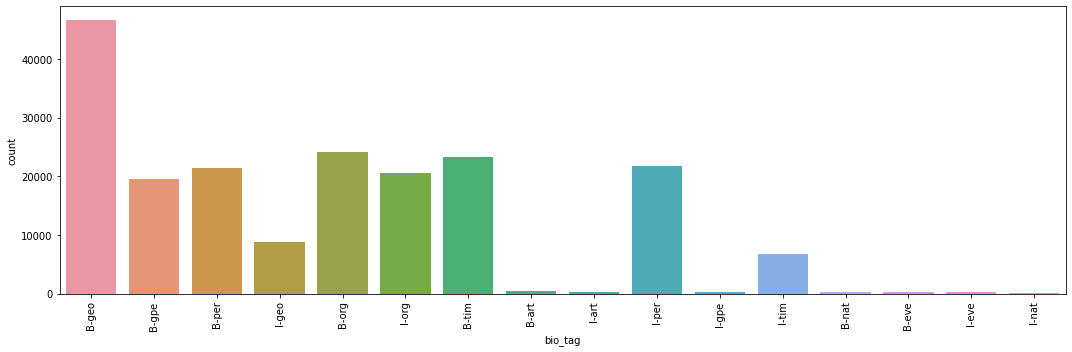

In [16]:
#Words distribution across Tags without O tag
import seaborn as sns
plt.figure(figsize=(15, 5))
ax = sns.countplot('bio_tag', data=voa_data.loc[voa_data['bio_tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

todo: add wordshape. from spacy for example

In [0]:
def get_sentences(df, word_col='word', pos_col='pos', 
                  tag_col='bio_tag', id_col='text_id'):
    """func to get the sentences in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_n, Tag_n)]"""
    
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s[word_col].values.tolist(),
                                                       s[pos_col].values.tolist(),
                                                       s[tag_col].values.tolist())]
    grouped = df.groupby(id_col).apply(agg_func)
    sentences = [s for s in grouped]
    
    return sentences

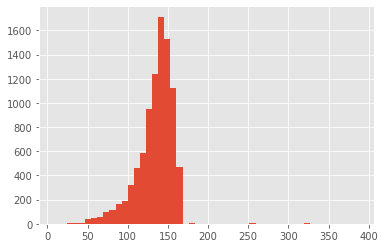

CPU times: user 1.8 s, sys: 138 ms, total: 1.93 s
Wall time: 1.93 s


In [18]:
%%time

word_pos_tag_sentences = get_sentences(voa_data)

#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in word_pos_tag_sentences], bins=50)
plt.show()

create featuretfransformer like in https://www.depends-on-the-definition.com/introduction-named-entity-recognition-python/

Feature engineering – 2 (1+1) 
* add quotes before and after as features  
 
grammatical words = closed set (~ stop words)  
Stemming + POS  
Word shape  
Ad hoc features ( +1)

In [0]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:], #replace with BPE
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def get_sent_labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [20]:
%%time 

X = [sent2features(s) for s in word_pos_tag_sentences]
y = [get_sent_labels(s) for s in word_pos_tag_sentences]

#make a split while the data is still sequential
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False, random_state=42)

def get_flatten_and_lengths(X, y):
    lengths = [len(x) for x in X]
    flatten_X = [item for sublist in X for item in sublist]
    flatten_y = [item for sublist in y for item in sublist]
    assert len(flatten_X) == np.array(lengths).sum()
    return flatten_X, flatten_y, lengths
X_train_flatten, y_train_flatten, lengths_train = get_flatten_and_lengths(X_train, y_train)
X_test_flatten, y_test_flatten, lengths_test = get_flatten_and_lengths(X_test, y_test)

# check values for both: train and test
voa_train_test = pd.concat([pd.Series(y_train_flatten).value_counts().rename('bio_tag_train'), 
                            pd.Series(y_test_flatten).value_counts().rename('bio_tag_test')], 
                            axis=1)
voa_train_test.sort_values(by='bio_tag_train', ascending=False)

CPU times: user 3.43 s, sys: 764 ms, total: 4.19 s
Wall time: 4.19 s


# Evaluation

In [0]:
def flatten(y):
    return list(chain.from_iterable(y))

def _flattens_y(func):
    @wraps(func)
    def wrapper(y_true, y_pred, *args, **kwargs):
        y_true_flat = flatten(y_true)
        y_pred_flat = flatten(y_pred)
        return func(y_true_flat, y_pred_flat, *args, **kwargs)
    return wrapper

In [22]:
def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def fbeta_macro(y_true, y_pred, beta=2):
    return fbeta_score(y_true, y_pred, average='macro', beta=beta)

scoring = [bio_f_score, f1_macro, fbeta_macro]
cv = KFold(n_splits=5, shuffle=False, random_state=42)
sequence_cv = SequenceKFold(lengths_train, n_folds=5, n_iter=1, shuffle=False, random_state=42, yield_lengths=True)

def evaluate_bio_clf_report(y_test, y_pred, labels, remove_O=True,
                            do_flatten=False):
    if remove_O:
        labels.remove('O') # remove 'O' label from evaluation
    sorted_labels = sorted(labels,key=lambda name: (name[1:], name[0])) # group B and I results
    if do_flatten:
        report = flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3)
    else:
        report = classification_report(y_test, y_pred, labels=sorted_labels, digits=3)
    return report

def evaluate_entity_clf_report(y_test, y_pred, lengths_test):
    
    if len(y_pred) != len(y_test):
        logging.info("lengths of y_pred and y_test are not equal. trying to unflat predictions via lengths")
        assert sum(lengths_test) == len(y_pred)
        
        y_pred_copy = deepcopy(y_pred)
        y_pred_unflatten = []
        for length in lengths_test:
            y_pred_unflatten.append(y_pred_copy[:length].tolist())
            y_pred_copy = np.delete(y_pred_copy, range(length))
    else:
        y_pred_unflatten = y_pred
        
    return entity_classification_report(y_test, y_pred_unflatten)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


todo: add classification report on entities and bio_tag levels

# Training models

## HMM

###Supervised
Given an observation sequence and the associated hidden states (real tags) we can learn the HMM parameters, that is, the matrices A and B.

In a HHM supervised scenario this is done by applying the Maximum Likelihood Estimation principle, which will compute the matrices.

This is achieved by counting how many times each event occurs in the corpus and normalizing the counts to form proper probability distributions.

In [0]:
pipe = Pipeline([('vectorizer', DictVectorizer(sparse=True)),
                 ('seq_clf', seqlearn_MHMM())])

In [0]:
def my_seq_cross_validate(estimator, X, y, cv, scoring):
    scores = dict((metric.__name__, []) for metric in scoring)
    for train, lengths_train, test, lengths_test in tqdm(list(cv), total=len(list(cv))):
        estimator_copy = deepcopy(estimator)
        model_name = estimator_copy.steps[-1][0]
        estimator_copy.fit(X[train], y[train], **{model_name+'__lengths': lengths_train})
        pred = estimator_copy.predict(X[test], **{'lengths': lengths_test})
        for metric in scoring:
            scores[metric.__name__].append(metric(y_true=y[test], y_pred=pred))
    
    scores_df = pd.DataFrame.from_dict(scores)
    scores_df.loc['mean'] = scores_df.mean()
    return scores_df

In [0]:
def grid_seq_cross_validate(parameter_dict, pipe, **kwargs):
    scores_dict = dict()
    grid_params_list = list(ParameterGrid(parameter_dict))
    for param_set in tqdm(grid_params_list, total=len(grid_params_list)):
        pipe_copy = deepcopy(pipe)
        # assuming that last step of pipeline is model
        pipe_copy[-1].__dict__.update(param_set)
        scores = my_seq_cross_validate(pipe_copy, **kwargs)
        scores_dict[str(pipe_copy[-1])] = scores
    return scores_dict

In [0]:
parameter_dict = {
    #Given a trained HMM i.e., the transition matrixes A and B, and a new observation sequence W=w1,w2,…,wN we want to find the sequence of states T=t1,t2,…,tN that best explains it.
    #This is can be achieved by using the Viterbi algorithm, that finds the best state assignment to the sequence T1…TN as a whole. 
    #There is another algorithm, Posterior Decoding (best-first) which consists in picking the highest state posterior for each position i in the sequence independently.
    'decode':['viterbi', 'bestfirst'], 
    'alpha':[0.001, 0.01, 0.1, 1.0]
}

In [0]:
%%time

scores_dict = grid_seq_cross_validate(parameter_dict, 
                                      pipe, 
                                      X=np.array(X_train_flatten),
                                      y=np.array(y_train_flatten),
                                      cv=sequence_cv,
                                      scoring=scoring)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until




CPU times: user 2min 26s, sys: 1.59 s, total: 2min 28s
Wall time: 2min 28s


In [0]:
scores_df = pd.concat(scores_dict.values(), keys=scores_dict.keys(), axis=1)
scores_df.T

0  ...      mean
MultinomialHMM(alpha=0.001, decode='viterbi')   bio_f_score  0.602240  ...  0.601818
                                                f1_macro     0.286838  ...  0.287269
                                                fbeta_macro  0.258712  ...  0.258485
MultinomialHMM(alpha=0.001, decode='bestfirst') bio_f_score  0.675595  ...  0.674505
                                                f1_macro     0.402382  ...  0.382823
                                                fbeta_macro  0.358670  ...  0.342333
MultinomialHMM(alpha=0.01, decode='viterbi')    bio_f_score  0.569115  ...  0.570155
                                                f1_macro     0.262675  ...  0.263328
                                                fbeta_macro  0.233159  ...  0.233046
MultinomialHMM(alpha=0.01, decode='bestfirst')  bio_f_score  0.675015  ...  0.674321
                                                f1_macro     0.379256  ...  0.362950
                                                fbeta_macro  0.340797  ...  0.327583
MultinomialHMM(alpha=0.1, decode='viterbi')     bio_f_score  0.458375  ...  0.459011
                                                f1_macro     0.202655  ...  0.201022
                                                fbeta_macro  0.173546  ...  0.172065
MultinomialHMM(alpha=0.1, decode='bestfirst')   bio_f_score  0.663210  ...  0.663272
                                                f1_macro     0.333049  ...  0.332700
                                                fbeta_macro  0.298961  ...  0.298410
MultinomialHMM(alpha=1.0, decode='viterbi')     bio_f_score  0.161203  ...  0.160512
                                                f1_macro     0.090295  ...  0.088777
                                                fbeta_macro  0.082487  ...  0.081439
MultinomialHMM(alpha=1.0, decode='bestfirst')   bio_f_score  0.599918  ...  0.601502
                                                f1_macro     0.280395  ...  0.279875
                                                fbeta_macro  0.244576  ...  0.244275

[24 rows x 6 columns]

Less alpha show better result. Ceteris paribus, bestfirst performs better

In [0]:
%%time
pipe = Pipeline([('vectorizer', DictVectorizer(sparse=True)),
                 ('seq_clf', seqlearn_MHMM(alpha=0.001, decode='bestfirst'))])
pipe.fit(X_train_flatten, y_train_flatten, **{'seq_clf__lengths': lengths_train})
y_pred_flatten = pipe.predict(X_test_flatten, **{'lengths': lengths_test})
print(y_pred_flatten[:15], '\n', y_test_flatten[:15])

['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'] 
 ['O', 'B-org', 'O', 'B-per', 'I-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O']
CPU times: user 4.14 s, sys: 25.8 ms, total: 4.16 s
Wall time: 4.17 s


In [0]:
np.unique(y_pred_flatten)

array(['O'], dtype='<U5')

In [0]:
np.unique(y_test_flatten)

array(['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per',
       'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org',
       'I-per', 'I-tim', 'O'], dtype='<U5')

In [0]:
bio_f_score(y_test_flatten, y_pred_flatten)

0.0

In [0]:
bio_clf_report = evaluate_bio_clf_report(y_test_flatten, y_pred_flatten, 
                                         labels=list(estimator.classes_),
                                         do_flatten=False)
entity_clf_report = evaluate_entity_clf_report(y_test, y_pred_flatten, lengths_test)
print('*****BIO-tag LEVEL*****\n', bio_clf_report, '\n*****ENTITY LEVEL*****\n', entity_clf_report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.000     0.000     0.000        72
       I-art      0.000     0.000     0.000        54
       B-eve      0.800     0.218     0.343        55
       I-eve      0.000     0.000     0.000        41
       B-geo      0.763     0.793     0.778      9387
       I-geo      0.771     0.319     0.451      1744
       B-gpe      0.979     0.816     0.890      3843
       I-gpe      1.000     0.306     0.468        36
       B-nat      0.625     0.167     0.263        30
       I-nat      0.000     0.000     0.000         8
       B-org      0.788     0.257     0.388      4999
       I-org      0.468     0.020     0.039      4274
       B-per      0.694     0.514     0.591      4291
       I-per      0.873     0.544     0.670      4343
       B-tim      0.913     0.678     0.778      4691
       I-tim      0.991     0.081     0.150      1415

   micro avg      0.816     0.519     0.635     39283
 

###Handmade
The most trivial model = supervised HMM:
Take hmmlearn (former sklearn), modify MultinomialHMM (I.e. inherit a new class from _BaseHMM making it a modified copy of the latter) to allow for supervised HMM training. The states of the HMM model = the NE tags.  
NOTE: may use NaiveBayes to learn emission probabilities in a supervized manner.
Or implement from scratch (with Viterbi for prediction).  
NOTE: use tuples of features for X (not just the word, but additional info).  
NOTE: use smoothing for state transitions.


In [0]:
from hmmlearn.base import _BaseHMM
import scipy.sparse as sp
from scipy.special import logsumexp
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils import check_array

In [0]:
def array2d(X, dtype=None, order=None, copy=False):
    """Returns at least 2-d array with data from X"""
    if sp.issparse(X):
        raise TypeError('A sparse matrix was passed, but dense data '
                        'is required. Use X.toarray() to convert to dense.')
    X_2d = np.asarray(np.atleast_2d(X), dtype=dtype, order=order)
    if X is X_2d and copy:
        X_2d = safe_copy(X_2d)
    return X_2d


def _atleast2d_or_sparse(X, dtype, order, copy, sparse_class, convmethod,
                         check_same_type):
    if sp.issparse(X):
        logging.info('X is sparse. Convert to csr if needed')
        if check_same_type(X) and X.dtype == dtype:
            X = getattr(X, convmethod)(copy=copy)
        elif dtype is None or X.dtype == dtype:
            X = getattr(X, convmethod)()
        else:
            X = sparse_class(X, dtype=dtype)
        X.data = np.array(X.data, copy=False, order=order)
    else:
        logging.info('Converting X to array2d')
        X = array2d(X, dtype=dtype, order=order, copy=copy)
    return X


def atleast2d_or_csr(X, dtype=None, order=None, copy=False):
    """Like numpy.atleast_2d, but converts sparse matrices to CSR format
    Also, converts np.matrix to np.ndarray.
    """
    return _atleast2d_or_sparse(X, dtype, order, copy, sp.csr_matrix,
                                "tocsr", sp.isspmatrix_csr)


def count_trans(y, n_classes):
    """Count transitions in a target vector.
    Parameters
    ----------
    y : array of integers, shape = n_samples
    n_classes : int
        Number of distinct labels.
    """
    trans = np.zeros((n_classes, n_classes), 
                     #dtype=np.intp
                     )

    for i in range(y.shape[0] - 1):
        trans[y[i], y[i + 1]] += 1
    return trans


def iter_from_X_lengths(X, lengths):
    if lengths is None:
        yield 0, len(X)
    else:
        n_samples = X.shape[0]
        end = np.cumsum(lengths).astype(np.int32)
        start = end - lengths
        if end[-1] > n_samples:
            raise ValueError("more than {:d} samples in lengths array {!s}"
                             .format(n_samples, lengths))

        for i in range(len(lengths)):
            yield start[i], end[i]


class my_hmm(hmmlearn_MHMM):
    def __init__(self, algorithm="viterbi", alpha=.01, **kwargs):
        self.alpha = alpha
        self.algorithm = algorithm
        hmmlearn_MHMM.__init__(self, **kwargs)

    def fit_supervised(self, X, y, lengths):
        """Fit HMM model to data by applying the Maximum Likelihood Estimation 
        principle, which will compute the matrices. This is achieved by counting 
        how many times each event occurs in the corpus and normalizing the 
        counts to form proper probability distributions.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Feature matrix of individual samples.
        y : array-like, shape (n_samples,)
            Target labels.
        lengths : array-like of integers, shape (n_sequences,)
            Lengths of the individual sequences in X, y. The sum of these
            should be n_samples.
        """

        alpha = self.alpha
        if alpha <= 0:
            raise ValueError("alpha should be >0, got {0!r}".format(alpha))

        X = atleast2d_or_csr(X)
        self.n_visible = X.shape[1]
        classes, y_indices = np.unique(y, return_inverse=True)
        self.n_hidden = len(classes)
        self.classes = classes
        lengths = np.asarray(lengths)
        # to list of one-hot vectors shape of (n_samples, unique_labels)
        Y = y_indices.reshape(-1, 1) == np.arange(len(classes))
        #return X, Y

        end_indices = np.cumsum(lengths)
        start_indices = end_indices - lengths
        end_indices -= 1

        # how much times each tag was at the beginning of the sequence
        log_init_prob = np.log(Y[start_indices].sum(axis=0) + alpha)
        # softmax, smoothing here is also taken into account 
        # (alpha taken the number of times equal number of classes)
        normalized_log_init_prob = log_init_prob - logsumexp(log_init_prob)
        init_prob = np.exp(normalized_log_init_prob)
        
        # how many times each tag was at the end of the sequence
        log_final_prob = np.log(Y[end_indices].sum(axis=0) + alpha)
        normalized_log_final_prob = log_final_prob - logsumexp(log_final_prob)
        final_prob = np.exp(normalized_log_final_prob)

        # how many times each feature occured with each tag
        log_emission_prob = np.log(safe_sparse_dot(Y.T, X) + alpha)
        normalized_log_emission_prob = log_emission_prob - logsumexp(log_emission_prob, axis=1)[:, np.newaxis]
        emission_prob = np.exp(normalized_log_emission_prob)

        log_trans_prob = np.log(count_trans(y_indices, len(classes)) + alpha)
        normalized_log_trans_prob = log_trans_prob - logsumexp(log_trans_prob, axis=1)[:, np.newaxis]
        trans_prob = np.exp(normalized_log_trans_prob)

        self.startprob_ = init_prob
        self.transmat_ = trans_prob
        self.emissionprob_ = emission_prob 
        self.n_components = self.n_hidden  

    def forward(self, input_seq):
        """Func to calculate forward probabilities, i.e. that the HMM will be in 
        a particular hidden state at a particular time step after emitting first
        t number of visible words from input_seq.
        Parameters
        ----------
        input_seq : {array-like, sparse matrix}, shape (n_samples, n_features)
            Feature matrix of individual samples.
        Returns
        -------
        forward_prob : np.array, shape(n_samples, n_hidden)
            Matrix of forward probabilities
        """
        input_seq_len = input_seq.shape[0]
        input_seq = atleast2d_or_csr(input_seq)

        forward_prob = np.zeros((input_seq_len, self.n_hidden))
        # element-wise multiplication
        forward_prob[0, :] = self.startprob_ * self.emissionprob_[:, input_seq[0]]
    
        for t in range(1, input_seq_len):
            for j in range(self.n_hidden):
                # probability that there will be a transition from any hidden 
                # state at (t−1) to a particular state j at time step t.
                state_j_prob = forward_prob[t - 1].dot(selt.transmat_[:, j])
                forward_prob[t, j] = state_j_prob * self.emissionprob_[j, input_seq[t]]
        return forward_prob
    
    def backward(self, input_seq):
        """Func to calculate backward probabilities, i.e. that the HMM will be in 
        a particular hidden state at a particular time step and will generate 
        the remaining part visible words from input_seq.
        Parameters
        ----------
        input_seq : {array-like, sparse matrix}, shape (n_samples, n_features)
            Feature matrix of individual samples.
        Returns
        -------
        backward_prob : np.array, shape(n_samples, n_hidden)
            Matrix of backward probabilities
        """
        input_seq_len = input_seq.shape[0]
        input_seq = atleast2d_or_csr(input_seq)

        backward_prob = np.zeros((input_seq_len, self.n_hidden))
        # setting last column to 1
        backward_prob[input_seq_len - 1] = np.ones((self.n_hidden))
    
        # Loop in backward way from T-1 to
        # Due to python indexing the actual loop will be T-2 to 0
        for t in range(input_seq_len - 2, -1, -1):
            for j in range(self.n_hidden):
                backward_prob[t, j] = (backward_prob[t + 1] * self.emissionprob_[:, input_seq[t + 1]]).dot(self.transmat_[j, :])
        return backward_prob

    def viterbi(self, input_seq):
        """Func to calculate forward probabilities, i.e. that the HMM will be in 
        a particular hidden state at a particular time step after emitting first
        t number of visible words from input_seq.
        Parameters
        ----------
        input_seq : {array-like, sparse matrix}, shape (n_samples, n_features)
            Feature matrix of individual samples.
        Returns
        -------
        forward_prob : np.array, shape(n_samples, n_hidden)
            Matrix of forward probabilities
        """
        input_seq_len = input_seq.shape[0]
        input_seq = atleast2d_or_csr(input_seq)
    
        omega = np.zeros((input_seq_len, self.n_hidden))
        omega[0, :] = self.startprob_ * self.emissionprob_[:, input_seq[0]]
    
        prev = np.zeros((input_seq_len - 1, self.n_hidden))
    
        for t in range(1, input_seq_len):
            for j in range(self.n_hidden):
                # Same as Forward Probability
                state_j_prob = forward_prob[t - 1].dot(selt.transmat_[:, j])
                forward_prob[t, j] = state_j_prob * self.emissionprob_[j, input_seq[t]]
    
                # This is the most probable state given previous state at time t (1)
                prev[t - 1, j] = np.argmax(forward_prob)
    
                # This is the probability of the most probable state (2)
                omega[t, j] = np.max(forward_prob)
    
        # Path Array
        viterbi_path = np.zeros(input_seq_len)
        # Find the most probable last hidden state
        last_state = np.argmax(omega[input_seq_len - 1, :])
        viterbi_path[0] = last_state
    
        backtrack_index = 1
        for i in range(input_seq_len - 2, -1, -1):
            viterbi_path[backtrack_index] = prev[i, int(last_state)]
            last_state = prev[i, int(last_state)]
            backtrack_index += 1
    
        # Flip the path array since we were backtracking
        viterbi_path = np.flip(viterbi_path, axis=0)
    
        # Convert numeric values to actual hidden states
        result = []
        for s in viterbi_path:
            result.append(self.classes[s])    
        return result

    def _decode_viterbi(self, X):
        if sp.issparse(X):
            X = X.toarray()
        framelogprob = self._compute_log_likelihood(X)
        return self._do_viterbi_pass(framelogprob)

    def decode(self, X, lengths=None, algorithm=None):
        """Find most likely state sequence corresponding to ``X``.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Feature matrix of individual samples.
        lengths : array-like of integers, shape (n_sequences, ), optional
            Lengths of the individual sequences in ``X``. The sum of
            these should be ``n_samples``.
        algorithm : string
            Decoder algorithm. Must be one of "viterbi" or "map".
            If not given, :attr:`decoder` is used.
        Returns
        -------
        logprob : float
            Log probability of the produced state sequence.
        state_sequence : array, shape (n_samples, )
            Labels for each sample from ``X`` obtained via a given
            decoder ``algorithm``.
        See Also
        --------
        score_samples : Compute the log probability under the model and
            posteriors.
        score : Compute the log probability under the model.
        """
        algorithm = algorithm or self.algorithm
        decoder = {
            "viterbi": self._decode_viterbi,
            "map": self._decode_map
        }[algorithm]

        X = check_array(X, accept_sparse=True)
        n_samples = X.shape[0]
        logprob = 0
        state_sequence = np.empty(n_samples, dtype=int)
        for i, j in iter_from_X_lengths(X, lengths):
            # XXX decoder works on a single sample at a time!
            logprobij, state_sequenceij = decoder(X[i:j])
            logprob += logprobij
            state_sequence[i:j] = state_sequenceij

        return logprob, state_sequence

In [0]:
%%time 
dv = DictVectorizer(sparse=True, dtype=int)
X_train_flatten_vect = dv.fit_transform(X_train_flatten)
display(X_train_flatten_vect, X_train_flatten_vect.shape)

<984882x29197 sparse matrix of type '<class 'numpy.int64'>'
	with 1984430 stored elements in Compressed Sparse Row format>

(984882, 29197)

CPU times: user 2.14 s, sys: 10.1 ms, total: 2.15 s
Wall time: 2.16 s


In [0]:
inst = my_hmm()
inst.fit_supervised(X_train_flatten_vect, y_train_flatten, lengths=lengths_train)
print(inst.startprob_.shape)
print(inst.transmat_.shape)
print(inst.emissionprob_.shape)

INFO      [2020-04-11 13:17:41,539] : X is sparse. Convert to csr if needed
(17,)
(17, 17)
(17, 29197)


In [0]:
inst.emissionprob_.max(axis=1)

array([0.99982302, 0.99978742, 0.99989626, 0.99988842, 0.99975034,
       0.99989546, 0.99989668, 0.99989834, 0.99979614, 0.99976735,
       0.99989588, 0.99973787, 0.99927933, 0.99989821, 0.99989834,
       0.99989455, 0.99989863])

In [0]:
inst.emissionprob_.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [0]:
inst.predict(X_train_flatten_vect[:np.cumsum(lengths_train[:2])[-1]].toarray(), lengths_train[:2])

ValueError: ignored

In [0]:
np.cumsum(lengths_train[:10])[-1]

1341

In [0]:
inst = my_hmm(n_components=17, verbose=2)
inst.fit(X_train_flatten_vect[:np.cumsum(lengths_train[:2])[-1]].toarray(), lengths_train[:2])

         1    -5220923.2498             +nan
         2       -6305.3314    +5214617.9184
         3       -6304.7750          +0.5564
         4       -6304.5293          +0.2457
         5       -6304.4086          +0.1208
         6       -6304.3395          +0.0690
         7       -6304.2916          +0.0480
         8       -6304.2517          +0.0399
         9       -6304.2142          +0.0375
        10       -6304.1764          +0.0378


my_hmm(algorithm='viterbi', alpha=0.01)

In [0]:
inst.decode(X_train_flatten_vect, lengths=lengths_train, algorithm='viterbi')

ValueError: ignored

In [0]:
gen = iter_from_X_lengths(X_train_flatten_vect, lengths_train)
start, stop = next(gen)
X_train_flatten_vect[start:stop]

<153x29197 sparse matrix of type '<class 'numpy.float64'>'
	with 308 stored elements in Compressed Sparse Row format>

In [0]:
X_train_flatten_vect[start:stop].toarray()

array([[ True, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False]])

In [0]:
np.concatenate(X_train_flatten_vect[start:stop].toarray())

array([ True, False,  True, ..., False, False, False])

In [0]:
log_mask_zero(inst.emissionprob_)[:, np.concatenate(X_train_flatten_vect[start:stop].toarray())].T

IndexError: ignored

In [0]:
len(X_train_flatten_vect[0].todense().tolist()[0]), inst.emissionprob_.shape

(29197, (17, 29197))

In [0]:
safe_sparse_dot(Y.T, X)

In [0]:
np.array(X_train_flatten_vect[0].todense()).shape

(1, 29197)

In [0]:
np.concatenate(np.array(X_train_flatten_vect[0].todense())).shape

(29197,)

In [0]:
inst.emissionprob_[:, X_train_flatten_vect[0].todense().tolist()[0]].T

array([[1.79724896e-03, 2.53787974e-03, 3.19320133e-04, 1.47667295e-03,
        3.05838456e-05, 3.38702267e-04, 3.09628844e-04, 8.62532772e-04,
        1.96475234e-05, 2.61117059e-05, 7.78138170e-04, 3.02142188e-05,
        3.24706952e-05, 3.20515902e-06, 2.36688071e-06, 1.11486449e-05,
        5.13995696e-05],
       [1.79724896e-03, 2.53787974e-03, 3.19320133e-04, 1.47667295e-03,
        3.08896841e-03, 3.38702267e-04, 3.09628844e-04, 8.62532772e-04,
        1.98439987e-03, 2.63728229e-03, 7.78138170e-04, 3.05163610e-03,
        3.27954021e-03, 3.23721061e-04, 2.39054952e-04, 1.12601313e-03,
        5.13995696e-05],
       [1.77945442e-05, 2.51275222e-05, 3.16158547e-06, 1.46205243e-05,
        3.05838456e-05, 3.35348779e-06, 3.06563212e-06, 8.53992844e-06,
        1.96475234e-05, 2.61117059e-05, 7.78138170e-04, 3.02142188e-05,
        3.24706952e-05, 3.20515902e-06, 2.36688071e-06, 1.11486449e-05,
        5.13995696e-05]])

In [0]:
inst.emissionprob_[:, [1,2,3]]

array([[9.42533719e-06, 3.60999840e-01, 9.42533719e-06],
       [1.22553525e-05, 3.19876956e-01, 1.22553525e-05],
       [1.05579543e-04, 4.90793424e-01, 1.31809666e-07],
       [6.07912480e-05, 4.72599328e-01, 3.02444020e-07],
       [1.46634016e-05, 2.85950995e-01, 1.46634016e-05],
       [5.13567771e-05, 4.88886112e-01, 2.55506354e-07],
       [2.87985504e-07, 4.91821932e-01, 2.87985504e-07],
       [2.69103913e-05, 4.95870854e-01, 2.66439518e-07],
       [1.17100132e-05, 3.29063082e-01, 1.17100132e-05],
       [1.36617621e-05, 3.00572428e-01, 1.36617621e-05],
       [6.88611807e-07, 4.89879128e-01, 6.88611807e-07],
       [1.53381291e-05, 2.76101661e-01, 1.53381291e-05],
       [2.59087494e-05, 1.21797031e-01, 2.59087494e-05],
       [3.07955278e-05, 4.95533886e-01, 3.04906215e-07],
       [2.84058872e-07, 4.95853451e-01, 2.84058872e-07],
       [1.81835123e-04, 4.86703872e-01, 9.04652356e-07],
       [4.38063264e-03, 4.96572206e-01, 1.45422796e-03]])

In [0]:
inst.emissionprob_[:, X_train_flatten_vect[0]]

IndexError: ignored

In [0]:
np.unique(X_train_flatten_vect[0].todense().tolist())

array([0., 1.])

In [0]:
matrix.tolist()

In [0]:
atleast2d_or_csr(X_train_flatten_vect)[0]

INFO      [2020-04-07 12:11:03,465] : X is sparse


<1x29197 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [0]:
inst.viterbi(X_train_flatten_vect)

IndexError: ignored

In [0]:
inst.emissionprob_[:, X_train_flatten_vect[0].todense()]

IndexError: ignored

###Unsupervised
use hmmlearn

In [0]:
np.array(X_train_flatten).reshape(-1, 1).shape

(984882, 1)

In [0]:
np.array(X_train_flatten).shape

(984882,)

In [0]:
unsupervised_hmm = hmmlearn_MHMM(n_components=unique_labels)
unsupervised_hmm.fit(np.array(X_train_flatten).reshape(-1, 1), lengths_train)

TypeError: ignored

## CRF

In [0]:
def run_rand_search(X_train, y_train, parameters):
    search = RandomizedSearchCV(estimator=CRF(),
                            param_distributions=parameters,
                            n_iter=10, scoring={metric.__name__:make_scorer(_flattens_y(metric)) for metric in scoring}, 
                            n_jobs=-1,
                            verbose=2,
                            cv=KFold(n_splits=3, shuffle=False, random_state=42),
                            refit='bio_f_score'#False,
                            )
    search.fit(X_train, y_train)
    return search

def show_search_results(search):
    full_df = pd.DataFrame(search.cv_results_)
    df_cutted = full_df.drop([k for k in search.cv_results_.keys() if any(col in k for col in ['split','std', 'params'])], axis=1)

    print('best params:', search.best_params_)
    print('best CV score:', search.best_score_)
    print('model size: {:0.2f}M'.format(search.best_estimator_.size_ / 1000000))

    pred_unflatten = search.predict(X_test)
    bio_clf_report = evaluate_bio_clf_report(y_test, pred_unflatten, 
                                            labels=list(search.best_estimator_.classes_),
                                            do_flatten=True)
    entity_clf_report = evaluate_entity_clf_report(y_test, pred_unflatten, lengths_test)
    print('*****BIO-tag LEVEL*****\n', bio_clf_report, '\n*****ENTITY LEVEL*****\n', entity_clf_report)

    return full_df, df_cutted, pred_unflatten

####Simple features (bias, lower, BOS, EOS) without tuning

In [0]:
%%time 

crf=CRF(algorithm='lbfgs',
         c1=0.1,
         c2=0.1,
         max_iterations=100,
         all_possible_transitions=False)

scores = cross_validate(crf, X_train, y_train, cv=cv, n_jobs=-1, 
                        scoring={metric.__name__:make_scorer(_flattens_y(metric)) for metric in scoring}, 
                        verbose=100, return_estimator=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pickling array (shape=(5866,), dtype=int64).
Pickling array (shape=(1467,), dtype=int64).
Pickling array (shape=(5866,), dtype=int64).
Pickling array (shape=(1467,), dtype=int64).
Pickling array (shape=(5866,), dtype=int64).
Pickling array (shape=(1467,), dtype=int64).
Pickling array (shape=(5867,), dtype=int64).
Pickling array (shape=(1466,), dtype=int64).
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
Pickling array (shape=(5867,), dtype=int64).
Pickling array (shape=(1466,), dtype=int64).
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.6min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
CPU times: user 1min 44s, sys: 564 ms, total: 1min 44s
Wall time: 3min 6s


In [0]:
pd.DataFrame({k:v for k,v in scores.items() if 'test_' in k})

,test_bio_f_score,test_f1_macro,test_fbeta_macro
0,0.0,0.053810,0.056710
1,0.0,0.053813,0.056711
2,0.0,0.053776,0.056695
3,0.0,0.053782,0.056698
4,0.0,0.053735,0.056677


#### All features

#### GB methods

In [26]:
parameters = {'algorithm': ['lbfgs'], 
              'c1': [0.1, 0.01], 
              'c2': [0.1, 0.01],
              'all_possible_transitions': [True, False]}

search = run_rand_search(X_train, y_train, parameters)
full_df, df_cutted, pred_unflatten = show_search_results(search)
df_cutted

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 575.4min finished


best params: {'c2': 0.1, 'c1': 0.1, 'all_possible_transitions': True, 'algorithm': 'lbfgs'}
best CV score: 0.8442490525177447
model size: 3.13M
*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.452     0.194     0.272        72
       I-art      0.467     0.259     0.333        54
       B-eve      0.386     0.309     0.343        55
       I-eve      0.194     0.146     0.167        41
       B-geo      0.872     0.910     0.890      9387
       I-geo      0.813     0.818     0.815      1744
       B-gpe      0.974     0.956     0.965      3843
       I-gpe      0.812     0.722     0.765        36
       B-nat      0.846     0.367     0.512        30
       I-nat      0.833     0.625     0.714         8
       B-org      0.805     0.729     0.765      4999
       I-org      0.822     0.782     0.802      4274
       B-per      0.836     0.839     0.838      4291
       I-per      0.835     0.893     0.863      4343
       B-tim      0.

,mean_fit_time,mean_score_time,param_c2,param_c1,param_all_possible_transitions,param_algorithm,mean_test_bio_f_score,rank_test_bio_f_score,mean_test_f1_macro,rank_test_f1_macro,mean_test_fbeta_macro,rank_test_fbeta_macro
0,5078.268208,13.006236,0.1,0.1,True,lbfgs,0.844249,1,0.639689,3,0.623642,4
1,7884.569026,14.014825,0.01,0.1,True,lbfgs,0.839618,6,0.633747,6,0.620083,6
2,5042.338612,13.442750,0.1,0.01,True,lbfgs,0.843070,4,0.639646,4,0.624001,3
3,8294.303088,12.860991,0.01,0.01,True,lbfgs,0.833200,8,0.624828,7,0.614282,7
4,3874.859576,13.421319,0.1,0.1,False,lbfgs,0.844139,2,0.640371,2,0.624631,2
5,5902.170344,14.100148,0.01,0.1,False,lbfgs,0.839809,5,0.635455,5,0.623602,5
6,3715.930987,13.114199,0.1,0.01,False,lbfgs,0.843072,3,0.641796,1,0.627176,1
7,4059.283186,8.828271,0.01,0.01,False,lbfgs,0.833361,7,0.623698,8,0.613546,8


In [27]:
parameters = {'algorithm': ['l2sgd'], 
              'c2': [0.1, 0.01],
              'all_possible_transitions': [True, False]}

search = run_rand_search(X_train, y_train, parameters)
full_df, df_cutted, pred_unflatten = show_search_results(search)
df_cutted

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs

best params: {'c2': 0.1, 'all_possible_transitions': True, 'algorithm': 'l2sgd'}
best CV score: 0.8391407477825762
model size: 8.93M
*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.419     0.181     0.252        72
       I-art      0.370     0.185     0.247        54
       B-eve      0.386     0.309     0.343        55
       I-eve      0.222     0.244     0.233        41
       B-geo      0.848     0.929     0.886      9387
       I-geo      0.769     0.833     0.799      1744
       B-gpe      0.974     0.956     0.965      3843
       I-gpe      0.844     0.750     0.794        36
       B-nat      0.684     0.433     0.531        30
       I-nat      0.714     0.625     0.667         8
       B-org      0.829     0.701     0.760      4999
       I-org      0.857     0.743     0.796      4274
       B-per      0.819     0.839     0.829      4291
       I-per      0.814     0.908     0.858      4343
       B-tim      0.921     0.8

,mean_fit_time,mean_score_time,param_c2,param_all_possible_transitions,param_algorithm,mean_test_bio_f_score,rank_test_bio_f_score,mean_test_f1_macro,rank_test_f1_macro,mean_test_fbeta_macro,rank_test_fbeta_macro
0,537.090520,15.092035,0.1,True,l2sgd,0.839141,1,0.627980,4,0.616956,4
1,454.976540,14.281680,0.01,True,l2sgd,0.826727,4,0.635371,3,0.623382,3
2,639.355750,14.025988,0.1,False,l2sgd,0.839034,2,0.639518,2,0.624699,2
3,397.214507,8.920340,0.01,False,l2sgd,0.835731,3,0.645080,1,0.626771,1


#### Non-GB methods

In [28]:
parameters = {'algorithm': ['ap', 'pa', 'arow']}

search = run_rand_search(X_train, y_train, parameters)
full_df, df_cutted, pred_unflatten = show_search_results(search)
df_cutted

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs

best params: {'algorithm': 'pa'}
best CV score: 0.8419118105485338
model size: 5.10M
*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.381     0.222     0.281        72
       I-art      0.481     0.241     0.321        54
       B-eve      0.438     0.382     0.408        55
       I-eve      0.303     0.244     0.270        41
       B-geo      0.871     0.909     0.890      9387
       I-geo      0.813     0.814     0.814      1744
       B-gpe      0.970     0.957     0.964      3843
       I-gpe      0.844     0.750     0.794        36
       B-nat      0.812     0.433     0.565        30
       I-nat      1.000     0.625     0.769         8
       B-org      0.800     0.729     0.763      4999
       I-org      0.845     0.764     0.802      4274
       B-per      0.826     0.841     0.833      4291
       I-per      0.832     0.895     0.862      4343
       B-tim      0.921     0.879     0.900      4691
       I-tim      0.853  

,mean_fit_time,mean_score_time,param_algorithm,mean_test_bio_f_score,rank_test_bio_f_score,mean_test_f1_macro,rank_test_f1_macro,mean_test_fbeta_macro,rank_test_fbeta_macro
0,215.801909,12.645297,ap,0.840907,2,0.643963,2,0.627523,2
1,246.379716,11.997287,pa,0.841912,1,0.645208,1,0.628318,1
2,205.178590,8.887510,arow,0.755875,3,0.578727,3,0.572033,3


##Bi-LSTM:
Use keras or tensorflow;  
https://github.com/hse-aml/natural-language-processing/blob/master/week2/week2-NER.ipynb  
A plus for incorporating CNN-layers;

In [0]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [0]:
unique_labels

In [0]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [0]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=170, sequences=X, padding="post", value=len(words) - 1) # ENDPAD

In [0]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [0]:
X = [sent2features(s) for s in word_pos_tag_sentences]
y = [get_sent_labels(s) for s in word_pos_tag_sentences]

#make a split while the data is still sequential
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False, random_state=42)